# 8. Search RNAi TE silencing pathway proteins
**Objective**: Determine the presence/absence of PIWI and RDRP (rrf1 & 3) genes in the genome assemblies.  
  
**Inputs**:  

+ Reference sequences from [Sarkies et al.](http://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1002061#pbio.1002061.s013):
    + `./silencing/1305245/S1_Data.txt` for PIWI and AGO reference sequences
    + `./silencing/1305245/S2_Data.txt` for RDRP (rrf1 & 3) reference sequences
+ Genome assembly files listed in `genome_assembly_files_v3.csv` and indicated with at least one +.
+ `silencing/exonerate/ad_hoc_additions.gb`: Manually curated from downstream output to evaluate some specific sequences.  
  
**Outputs**:  

+ GenBank and text files with exonerate outputs in `silencing/exonerate/`
+ `silencing/pathways`: a table indicating the presence or absence of the three genes
+ Output tree figures `silencing/exonerate/AGO.png` and `silencing/exonerate/RDRP.png`
  
**Strategy**  
  
+ Run exonerate to search for AGO, PIWI and RDRP sequences in the genome assemblies
+ Build trees and find monophyltic clades of PIWI, RRE1 and RRF3
+ Use a HMMER search to assert that RRF3 is missing from transcriptomes of some species

In [1]:
from reprophylo import *

## 8.1 Search from genes in genome assemblies
### Make a query file

In [2]:
from reprophylo import *
import os, itertools

# Make an output directory
if not os.path.exists('./silencing/exonerate/'):
    os.mkdir('./silencing/exonerate')

# sarkies sequence alignment filenames
clust_aln_filenames = ['./silencing/1305245/S1_Data.txt',
                       './silencing/1305245/S2_Data.txt']

#  Unalign and append the sequences
query_sequences = []

records = itertools.chain(*[list(SeqIO.parse(i, 'clustal')) for i in clust_aln_filenames])

for r in records:
    r.seq = Seq(str(r.seq).replace('-',''), alphabet=IUPAC.protein)
    query_sequences.append(r)
    
# Write the query file with unaligned sequences from both alignments
SeqIO.write(query_sequences,'silencing/exonerate/query.fasta','fasta')

33

### Run exonerate on all the genomes

In [ ]:
import TE
from reprophylo import *

# Query file
q = 'silencing/exonerate/query.fasta'

# A dictionary of target files
geno_dir = '/media/amir/DATA/work/Dropbox/Genomes/'
geno_dict = TE.genomes_dict('Genomes/', mode='+', code_file='genome_assembly_files_v3.csv')

for code in geno_dict:
    print code
    
    # The target file path
    db = '%s%s'%(geno_dir,geno_dict[code])
    
    # Run exonerate
    stats, results = exonerate(q, db, M=9000, m='protein2genome')
    
    # Write a text exonerate output file
    hndl = open('silencing/exonerate/%s.txt'%code,'wt')
    hndl.write(results)
    hndl.close()
    
    # Write a GenBank file with exonerate results
    gb_filename = exonerate_ryo_to_gb(q, db, stats, results).split()[-1]
    
    # Move the GenBank output file
    new_path = 'silencing/exonerate/%s'%(gb_filename.split('/')[-1])
    os.rename(gb_filename,new_path)

### Make sure seq ids in exonerate results are unique accross all the species

In [34]:
import glob
files= glob.glob("silencing/exonerate/*.gb")

seen = []

j=0
for f in [i for i in files if not 'fltr.gb' in i]:
    from Bio import SeqIO
    fixed_ids = []
    for r in SeqIO.parse(f,'gb'):
        if r.id in seen:
            r.id = "%s|%i"%(r.id, j)
            j+=1
        else:
            seen.append(r.id)
        fixed_ids.append(r)
    SeqIO.write(fixed_ids, f, 'gb')

### Get the sequence length of all the quaries
This will be used to calculate query coverage

In [6]:
qlengths = {}
for i in SeqIO.parse('silencing/1305245/S1_Data.txt','clustal'):
    qlengths[i.id] = len(str(i.seq).replace('-',''))

for i in SeqIO.parse('silencing/1305245/S2_Data.txt','clustal'):
    qlengths[i.id] = len(str(i.seq).replace('-',''))
    
qlengths['BMA-RRF-3']

1608

### Declare the proper name of each query. The original ID is not informative.

In [13]:
qid_to_protname = {
'tr|Q7KY08|':'AGO_Dmel',
'BUX.s01144':'AGO_Bxyl',
'g7616.t1_g':'AGO_Pred',
'EFV55930_E':'AGO_Tspi_tsp_03656',
'TMUE_s0141':'AGO_Tmur',
'F48F7.1a_C':'AGO_Cele_alg1',
'GS_10246_G':'AGO_GpalA',
'Bm4213_BM1':'AGO_Bmal_bm4213',
'GPLIN_0003':'AGO_GpalB',
'MhA1_Conti':'AGO_Mhap',
'sp|Q2Q5Y9|':'PIWI_Schm_wi1',
'sp|O76922|':'PIWI_Dmel_aub',
'sp|Q9VKM1|':'PIWI_Dmel_piwi',
'PPA23639_P':'PIWI_Papc_piwi',
'HCISE00858':'PIWI_Hcon',
'CBG11957_C':'PIWI_briC_prg1',
'D2030.6_CE':'PIWI_Cele_prg1',
'sp|Q8CDG1|':'PIWI_Mmus_piwil2',
'sp|Q7Z3Z4|':'PIWI_Hsap_piwil4',
'sp|Q96J94|':'PIWI_Hsap_piwil1',
'sp|Q9JMB7|':'PIWI_Mmus_piwil1',
'sp|O14227|':'RDRP_Spom_rdr1',
'RDR6_Ath':'RDRP_Ath_rdr6',
'sp|Q9LQV2|':'RDRP_Ath_rdr1',
'tr|G5EBQ3|':'RDRP_Cele_ego1',
'tr|G5ECM1|':'RDRP_Cele_rrf1',
'GPLIN_0010':'RDRP_Gpal_rdrp',
'tr|F1KQU8|':'RDRP_Asuu_rdrp1',
'Bm3605':'RDRP_Bmal_rdrp',
'tsp_RRF-3':'RDRP_Tspi_rrf3',
'tr|G5EE53|':'RDRP_Cele_rrf3',
'tr|F1KQR2|':'RDRP_Asuu_rdrp3',
'BMA-RRF-3':'RDRP_Bmal_rrf3'
}

## 8.2 Filter the exonerate results by length and % identity
### Filter preliminaries

In [4]:
%doctest_mode

Exception reporting mode: Plain
Doctest mode is: ON


In [5]:
def traget_location(exonerate_genbank_record, unrevcomp=True):
    
    """
    Takes a SeqRecord object produced by the ReproPhylo 
    exonerate toolkit and returns the begining and end of
    the match in the target sequence. If unrevcomp == True,
    it will make sure the begining is the smaller coordinate.
    The begining and end are real positions, ie, the first bp
    in the target is 1 and not 0.
    
    >>> from Bio import SeqIO
    >>> exonerate_genbank_record = list(SeqIO.parse('silencing/exonerate/Gpal.v1.0.fas.gb', 'genbank'))[0]
    
    >>> traget_location(exonerate_genbank_record)
    (139274, 154200)
    
    >>> traget_location(exonerate_genbank_record, unrevcomp=False)
    (154200, 139274)
    """
    
    # input has to be a SeqRecord object
    assert isinstance(exonerate_genbank_record, SeqRecord)
    
    # exonerate parameters are in the source feature
    source =  exonerate_genbank_record.features[0]
    
    # make sure this SeqRecord has ReproPhylo exonerate results
    if not all(['tbegin' in source.qualifiers.keys(),
                'tend' in source.qualifiers.keys()]):
        raise IOError('This function only works with SeqRecord objects'+
                      ' generated with the ReproPhylo exonerate tools')
        
    tbegin = int(source.qualifiers['tbegin'][0])
    tend = int(source.qualifiers['tend'][0])
    
    if unrevcomp and tbegin > tend:
        tbegin, tend = tend, tbegin
    
    return tbegin, tend
    
def is_overlapping(coords1, coords2):
    
    """
    Check if two ranges are overlapping. The ranges are each
    a list or tupple including of two values, the begining and end.
    The begining and end are included in the range.
    
    # overlapping ranges
    
    >>> coords1 = (10, 100)
    >>> coords2 = (50, 150)
    >>> is_overlapping(coords1, coords2)
    True
    
    >>> is_overlapping(coords2, coords1)
    True
    
    # Second range is revcomp and input is
    # list instead of tuple
    
    >>> coords1 = [10, 100]
    >>> coords2 = [150, 50]
    >>> is_overlapping(coords1, coords2)
    True
    
    # One range is completely nested in the other
    
    >>> coords1 = (10, 100)
    >>> coords2 = (20, 90)
    >>> is_overlapping(coords1, coords2)
    True
    
    >>> is_overlapping(coords2, coords1)
    True
    
    # The ranges overlap by a single position
    
    >>> coords1 = (10, 100)
    >>> coords2 = (100, 200)
    >>> is_overlapping(coords1, coords2)
    True
    
    >>> is_overlapping(coords2, coords1)
    True
    
    # The ranges do not overlap
    
    >>> coords1 = (10, 100)
    >>> coords2 = (200, 300)
    >>> is_overlapping(coords1, coords2)
    False
    """
    
    # inputs need to be lists or tuples
    assert all([isinstance(coords1,(list,tuple)),
                isinstance(coords2,(list,tuple))])
    
    for lst in [coords1, coords2]:
        
        # inputs need to have two values each
        assert len(lst) == 2
        
        # inputs values have to be all int
        for i in lst:
            assert isinstance(i, int)
    
    if any([coords2[0] <= coords1[0] <= coords2[1],
            coords2[0] <= coords1[1] <= coords2[1],
            coords1[0] <= coords2[0] <= coords1[1],
            coords1[0] <= coords2[1] <= coords1[1]]):
        return True
    else:
        return False
    
def compare_stat(stat, record0, record1, return_larger=True, return_first=True):
    
    """ Compare the given source quailfier between
        two SeqRecord object. qualifier values have to be numeric.
        By default, return the SeqRecord with the largest value.
        If the values are equal, by default return record0.
        
        # The score in record0 is bigger
        
        >>> filename = 'silencing/exonerate/Gpal.v1.0.fas.gb'
        >>> record0, record1 = list(SeqIO.parse(filename, 'genbank'))[0:2]
        >>> chosen_record = compare_stat('score', record0, record1)
        >>> print('record id: ', chosen_record.id)
        record id:  Gpal|fas|0
        >>> print('score: ', chosen_record.features[0].qualifiers['score'][0])
        score:  9389
        
        # The score in record1 is bigger
        
        >>> record1.features[0].qualifiers['score'][0], record0.features[0].qualifiers['score'][0] =\
            record0.features[0].qualifiers['score'][0], record1.features[0].qualifiers['score'][0]
        >>> chosen_record = compare_stat('score', record0, record1)
        >>> print('record id: ', chosen_record.id)
        record id:  Gpal|fas|1
        >>> print('score: ', chosen_record.features[0].qualifiers['score'][0])
        score:  9389
        
        # Return the record with the smaller value
        
        >>> record0, record1 = list(SeqIO.parse(filename, 'genbank'))[0:2]
        >>> chosen_record = compare_stat('score', record0, record1, return_larger=False)
        >>> print('record id: ', chosen_record.id)
        record id:  Gpal|fas|1
        >>> print('score: ', chosen_record.features[0].qualifiers['score'][0])
        score:  3361
        
        # The values are equel, return the first record
        
        >>> record1.features[0].qualifiers['score'][0] = record0.features[0].qualifiers['score'][0]
        >>> chosen_record = compare_stat('score', record0, record1)
        >>> print('record id: ', chosen_record.id)
        record id:  Gpal|fas|0
        >>> print('score: ', chosen_record.features[0].qualifiers['score'][0])
        score:  9389

        # The values are equal, return the second record
    
        >>> chosen_record = compare_stat('score', record0, record1, return_first=False)
        >>> print('record id: ', chosen_record.id)
        record id:  Gpal|fas|1
        >>> print('score: ', chosen_record.features[0].qualifiers['score'][0])
        score:  9389
            
        # Assertions fail
        
        >>> record1 = 'not a SeqRecord object'
        >>> chosen_record = compare_stat('score', record0, record1)
        Traceback (most recent call last):
            ...
        AssertionError
            
        >>> record0, record1 = list(SeqIO.parse(filename, 'genbank'))[0:2]
        >>> chosen_record = compare_stat('qtype', record0, record1)
        Traceback (most recent call last):
            ...
        IOError: stat qtype is not a numeral

    """
    
    # Check the the records are SeqRecord objects
    assert isinstance(record0, SeqRecord)
    assert isinstance(record1, SeqRecord)
    
    stats = []
    
    for r in [record0, record1]:
        
        # Get the srouce feature
        source = r.features[0]
        
        # Check if stat exists
        if not stat in source.qualifiers.keys():
            raise IOError('Record %s does not have stat %s. '(r.id, stat)+
                          'Is this an exonerate SeqRecord object'+
                          ' generated with ReproPhylo?')
            
        else:
            # Check if the stat in numeric
            try:
                float(source.qualifiers[stat][0])
            except:
                raise IOError('stat %s is not a numeral'%stat)
            
            # get the stat
            stats.append(float(source.qualifiers[stat][0]))
            
    if stats[0] > stats[1] and return_larger:
        return record0
    elif stats[0] > stats[1]:
        return record1
    elif stats[0] < stats[1] and return_larger:
        return record1
    elif stats[0] < stats[1]:
        return record0
    elif stats[0] == stats[1] and return_first:
        return record0
    elif stats[0] == stats[1]:
        return record1

def integrate_record_in_list(filtered_records, record, stat):
    
    """ Flags a new record for inclussion in the final list.
        If the record overlappes with a record already existing in the list
        and has better score, it removes the exsiting record.
        If the new record has a worse score than the overlapping existing record
        it flags the new record for exclusion.
        
        Actual inclussion of the new record in the filtered list, if flaged as such,
        is done outside this function, to allow custom modification of the record
        prior to its inclusion.
    """

    # The default status of the flag is to include the new record
    get_new_record = True
    record_contig = record.features[0].qualifiers['tid'][0]
    record_coords = traget_location(record)
    remove = []
    
    for fltrd_r in filtered_records:
        fltrd_r_contig = fltrd_r.features[0].qualifiers['tid'][0]
        fltrd_r_coords = traget_location(fltrd_r)
        
        # Check if the new record overlapps with any of the 
        # previously included records
        if (record_contig == fltrd_r_contig and
            is_overlapping(record_coords, fltrd_r_coords)):
            
            # If the new record overlappes with an existing one,
            # check which has better score
            retain_id = compare_stat('score', fltrd_r, record).id
            
            # If the previously exsiting record has a better score
            # mark the new one for exclusion
            if retain_id == fltrd_r.id:
                get_new_record = False
                
            # If the new record has a better score, mark the previously
            # included and overlapping record for removal
            elif retain_id == record.id:
                remove.append(fltrd_r.id)
    
    # remove records marked for removal
    if get_new_record and len(remove) > 0:
        filtered_records = [i for i in filtered_records if not i.id in remove]
    
    # return the flag indicating if to include the new record
    # and the updated filtered list.    
    return get_new_record, filtered_records

if __name__ == "__main__":
    import doctest
    doctest.testmod()    

### Actual filter
Only hits that are at least 61% identical to the query and 7% the length of the query (bu no less than 100 aa) are retained

In [8]:
import math, TE
geno_dict = TE.genomes_dict('Genomes/', mode='++', code_file='genome_assembly_files_v3.csv')

seen_ids = []
modifier = 0

for code in geno_dict:
    
    # Read the full exonerate results (gb file)
    genbank_filename = 'silencing/exonerate/%s.gb'%geno_dict[code]
    
    # This will hold the records that passed the filter
    filtered_records = []
    
    for r in SeqIO.parse(genbank_filename,'genbank'):
        get = False
        source = r.features[0]
        
        # This is the contig name:
        qid = source.qualifiers['qid'][0]
        
        # This is the minimal allowed length prop of the query
        # in the alignment
        qlen_catoff = qlengths[qid]*0.07
        
        # This is the actual length of the query in the alignment
        len_in_q = len(source.qualifiers['qfull'][0])
        
        # Check if the similarity is higher then 60% and that the
        # length of the query in the alignment is at least 100 AA
        # and at least 7% of the full query length
        if float(source.qualifiers['Psim'][0]) >= 61.0 and (len_in_q >= qlen_catoff and len_in_q > 100):
            get = True
            
        # Check if sequences that passed the filtering earlier overlap 
        # with this one. Keep only the highiest scoring among overlapping
        # matches
        if get:
            get, filtered_records = integrate_record_in_list(filtered_records, r, 'score')
            
        if get:
            # fix identical record ids accross gb files
            if r.id in seen_ids:
                r.id = "%s|%i"%(r.id,modifier)
                modifier += 1
            else:
                seen_ids.append(r.id)
            
            # Fix some metadata:
            
            # replace nonsensical qid with 
            # an informative one
            
            # make uniform gene names (ie, RDRP, AGO or PIWI)    
            qname = qid_to_protname[qid]
            gene = qname.split('_')[0]
            source.qualifiers['qname'] = [qname]
            cds = [f for f in r.features if f.type == 'CDS'][0]
            cds.qualifiers['gene'] = [gene]
            filtered_records.append(r)
         
    
    # Write the filtered records
    if len(filtered_records) > 0:
        SeqIO.write(filtered_records, 'silencing/exonerate/%s.fltr.gb'%geno_dict[code], 'genbank')

### Second pass additional data
The following tree reconstruction was run twice. The first pass only included sequences that passed the above filter. In the second pass, missing sequences (for example, when a clade IV species did not have the expected RRF3 ortholog) were looked for manually among the sequences that were filtered out. When a possible match was found, and there was no better match in the same locus, it was copied to the file `silencing/exonerate/ad_hoc_additions.gb`. Three seuences were added this way. 

In [19]:
# Fix the gene name of the three ad-hoc sequences
records = SeqIO.parse('silencing/exonerate/ad_hoc_additions.gb','genbank')
edited_records = []
for r in records:
    source = r.features[0]
    qid = source.qualifiers['qid'][0]
    # make uniform gene names (ie, RDRP, AGO or PIWI)    
    qname = qid_to_protname[qid]
    gene = qname.split('_')[0]
    source.qualifiers['qname'] = [qname]
    cds = [f for f in r.features if f.type == 'CDS'][0]
    cds.qualifiers['gene'] = [gene]
    edited_records.append(r)
SeqIO.write(edited_records, 'silencing/exonerate/ad_hoc_additions_edited.gb','genbank')

3

## 8.3 Build APO+PIWI and RDRP trees

In [7]:
from reprophylo import *
from glob import glob

### Include the filtered exonerate results and the query sequences in the data

In [ ]:
gb_names = [f for f in glob('silencing/exonerate/*.fltr.gb') 
            if f.split('/')[2].split('fltr')[0][:-1] in geno_dict.values()]

# This file was added only in the second pass. The first tree 
# reconstruction only included that passed the filter automatically.
gb_names.append('silencing/exonerate/ad_hoc_additions_edited.gb')


loci = [Locus('prot','CDS','AGO',['PIWI']),
        Locus('prot','CDS','RDRP',['RDRP'])]

# This is not the main Project file, this is another one
# only used for RNAi protein sequence trees
pr = Project(loci, git=False)

pr.read_embl_genbank(gb_names)
pr.read_alignment('silencing/1305245/S1_Data.txt','prot','CDS', 'AGO',format='clustal')
pr.read_alignment('silencing/1305245/S2_Data.txt','prot','CDS', 'RDRP',format='clustal')

# The sequences from the alignments were added to the pj.records list automatically.
# We only need them there, we don't want the actual alignments:
pr.alignments = {}

### Make sure there are no duplicate names

In [22]:
from itertools import chain

seen_ids = []

for f in [i for i in chain(*[r.features for r in pr.records])]:
    if f.qualifiers['feature_id'][0] in seen_ids:
        print f.qualifiers['feature_id'][0]
    else:
        seen_ids.append(f.qualifiers['feature_id'][0])

### Declare the name of the reference sequences and the genome code of the matches

In [23]:
# The query sequences are read as clustal and their id will be generated
# by the system

# This will replace the generated id with the original id 
# and will set the informative names of the query sequences

for r in pr.records:
    if 'denovo' in r.id:
        orig_id = r.features[0].qualifiers['original_id'][0]
        r.features[0].qualifiers['name'] = [qid_to_protname[orig_id]]
        r.features[0].qualifiers['qname'] = [qid_to_protname[orig_id]]
        r.features[0].qualifiers['code'] = ["ref"]
        r.features[0].qualifiers['tid'] = ["ref"]
    else:
        #print r.features[0].qualifiers['file'][0]
        r.features[0].qualifiers['code'] = [[c for c in geno_dict.keys() 
                                             if geno_dict[c] == r.features[0].qualifiers['file'][0]][0]]

### How many seqs in each dataset

In [25]:
pr.extract_by_locus()

for key in pr.records_by_locus:
    print key, len(pr.records_by_locus[key])

AGO 430
RDRP 340


In [31]:
# In the recond pass of tree reconstuction, 
# make sure the ad-hoc sequences were read into the database:
'Pana|asta|5_f0' in [r.id for r in pr.records_by_locus['RDRP']]

True

### Build the trees

In [33]:
# This is the project file containing the trees without the ad-hoc sequence addition:
#pr = unpickle_pj('silencing/reprophylo_project_relaxed_filter_fd_fJ')

# This project file contains the trees of the second pass, where three ad-hoc sequence
# addiotion:
pickle_pj(pr, 'silencing/reprophylo_project_relaxed_filter_and_ad_hoc_seqs')

linsi = AlnConf(pr, method_name='linsi', program_name='mafft',
                cmd='mafft', loci='all', CDSAlign=False,
                cline_args=dict(localpair=True, maxiterate=1000))
pr.align([linsi])

mafft --localpair --maxiterate 1000 290521430694882.7_AGO.fasta
mafft --localpair --maxiterate 1000 290521430694882.7_RDRP.fasta


In [ ]:
# This is the firts trimming iteration, the one that included only the sequences that passed 
# the filter without ad-hoc addition of sequences, and is the one that was used eventually.

# gt30 = TrimalConf(pr, method_name='gt30', trimal_commands={'gt': 0.3})
# pr.trim([gt30], cutoff=100)

# This is the trimming of the alignment that included the ad-hoc additions
gt30 = TrimalConf(pr, method_name='gt30', trimal_commands={'gt': 0.3})
pr.trim([gt30], cutoff=100)

### View the alignment

In [15]:
pr.show_aln('AGO@linsi@gt30')

pr.trimmed_alignments.keys()

['RDRP@linsi@gt30', 'AGO@linsi@gt30']

In [35]:
raxml = RaxmlConf(pr, method_name='fd_fJ', preset='fd_fJ', cmd='raxmlHPC-PTHREADS-AVX',
                  alns=['AGO@linsi@gt30',
                        'RDRP@linsi@gt30'], threads=2)
pr.tree([raxml])

raxmlHPC-PTHREADS-AVX -f d -m PROTGAMMAJTT -n 643801430696505.99_RDRP@linsi@gt300 -p 770 -s 643801430696505.99_RDRP@linsi@gt30.fasta -T 2 -N 1
raxmlHPC-PTHREADS-AVX -f J -m PROTGAMMAJTT -n 643801430696505.99_RDRP@linsi@gt301 -p 878 -s 643801430696505.99_RDRP@linsi@gt30.fasta -t RAxML_bestTree.643801430696505.99_RDRP@linsi@gt300 -T 2
raxmlHPC-PTHREADS-AVX -f d -m PROTGAMMAJTT -n 643801430696505.99_AGO@linsi@gt300 -p 523 -s 643801430696505.99_AGO@linsi@gt30.fasta -T 2 -N 1
raxmlHPC-PTHREADS-AVX -f J -m PROTGAMMAJTT -n 643801430696505.99_AGO@linsi@gt301 -p 394 -s 643801430696505.99_AGO@linsi@gt30.fasta -t RAxML_bestTree.643801430696505.99_AGO@linsi@gt300 -T 2


### Summary

Without the ad-hoc sequence addition  
`pickle_pj(pr, 'silencing/reprophylo_project_relaxed_filter_fd_fJ')`  
   
With the ad-hoc sequence addition  
`pickle_pj(pr, 'silencing/reprophylo_project_relaxed_filter_and_ad_hoc_seqs')`  
  
**The ad-hoc sequences turn out not to be  RRF3.  
I carry on with `771661428929921.16` in `silencing/reprophylo_project_relaxed_filter_fd_fJ`**

### This shows how the trees that made it into the paper were built
The order is scrambled. first mafft, second trimal and finaly raxml. This report says methods were not executed because the pickle file is older version than the reprophylo module, but they were. There are two RAxML methods, one with the `-f F` algorithm and the second with the `-f d` algorithm. The one taken forward into the analysis and paper is **`fd_fJ with ID 771661428929921.16.`**

In [2]:
for m in pr.used_methods.keys():
    print str(pr.used_methods[m])

TrimalConf named gt30 with ID 459051428929669.1
Alignments: RDRP@linsi,AGO@linsi 
Created on: Mon Apr 13 13:54:29 2015
Commands:
RDRP@linsi@gt30: trimal -in 459051428929669.1_RDRP@linsi.fasta -gt 0.3
AGO@linsi@gt30: trimal -in 459051428929669.1_AGO@linsi.fasta -gt 0.3

Environment:Platform: Linux-3.13.0-46-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2rev1026
 biopython version: 1.64
 dendropy version: 3.12.0
 cloud version: 2.8.5
 User: Amirs-PC
 Program and version: trimal: trimAl 1.2rev59\n
execution time:
28.7396178246

Core Methods section sentence:
The alignment(s) RDRP@linsi;AGO@linsi were trimmed using the program [This was not executed yet] [1].

Reference:
[This was not executed yet]

RaxmlConf named fF_fJ with ID 178301428675965.1
Alignments: RDRP@linsi@gt30,AGO@linsi@gt30 
Executed on: Fri Apr 10 15:26:05 2015
Commands:

## 8.4 Draw the trees

In [2]:
from reprophylo import *
#This is the one that made it to the paper
pr = unpickle_pj('silencing/reprophylo_project_relaxed_filter_fd_fJ', git=False)

pr.clear_tree_annotations()
pr.propagate_metadata()
supports = {'dimgray':[100,99]}
pr.annotate('silencing/exonerate','mid','mid',['feature_id',
                                               'source_code',
                                               'source_qname',
                                               'source_tid'],
            node_support_dict=supports, scale = 100,
            html='silencing/exonerate/trees.html')

DEBUG:Cloud:Log file (/root/.picloud/cloud.log) opened
/home/reprophylo/reprophylo.py:4781: UserWarning: Upgrading Project to v1
  warnings.warn('Upgrading Project to v1')


###Evidence for PIWI in Hoar
184 AA in Hoar (accession **`Howa|1fa|2`** in 
**`silencing/exonerate/Howardula_aoronymphium_clc_1.fa.fltr.gb`**) are 88.52% similar and 75.41% identical to the PIWI_Dmel_aub query and cluster as its close relative with short patristic distance and maximum sh-like support  
** Update 23/10/15: It is a drosophila contamination**

### Get a list of PIWI leaves out of the AGO tree

In [3]:
ago_t = pr.ft('AGO@linsi@gt30@fd_fJ')
ago_t.dist = 0
ago_t.set_outgroup(ago_t.get_midpoint_outgroup())

piwi_entry_ids = ago_t.get_common_ancestor('denovo10_f0',
                                           'c_re|cfa|587_f0').get_leaf_names()

piwi_entry_ids

returning tree object AGO@linsi@gt30@fd_fJ


['Hyps|fna|127_f0',
 'Hyps|fna|247_f0',
 'Hyps|fna|160_f0',
 'c_an|cfa|348_f0',
 'c_an|cfa|428_f0',
 'c_an|cfa|24_f0',
 'c_an|cfa|355_f0',
 'c_el|cfa|388_f0',
 'c_el|cfa|64_f0',
 'denovo16_f0',
 'c_re|cfa|673_f0',
 'c_ja|cfa|54_f0',
 'c_re|cfa|86_f0',
 'c_re|cfa|587_f0',
 'c_re|cfa|126_f0',
 'Caen|sfa|38_f0',
 'Caen|sfa|466_f0',
 'c_br|cfa|711_f0',
 'c_br|cfa|293_f0',
 'c_sp|cfa|254_f0',
 'denovo15_f0',
 'c_br|cfa|45|268_f0',
 'c_re|cfa|703_f0',
 'Hete|sfa|66_f0',
 'p_pa|cfa|295_f0',
 'denovo13_f0',
 'Hete|sfa|58_f0',
 'Osch|1fa|11_f0',
 'Osch|1fa|274_f0',
 'Angi|fa_4|14_f0',
 'dict|tfa|71_f0',
 'Angi|fa_4|15_f0',
 'Heli|fa_4|160_f0',
 'h_co|cfa|85_f0',
 'h_co|cfa|224_f0',
 'denovo14_f0',
 'Heli|fa_4|204_f0',
 'Hyps|fna|232_f0',
 'denovo17_f0',
 'denovo19_f0',
 'denovo20_f0',
 'denovo18_f0',
 'denovo12_f0',
 'Hyps|fna|95_f0',
 'Howa|1fa|38_f0',
 'denovo11_f0',
 'Howa|1fa|2_f0',
 'denovo10_f0']

### Indicate PIWI entries in the ReproPhylo Project
This is the Project for RNAi analysis, not the main Project file

In [4]:
from itertools import chain

for f in chain(*[r.features for r in pr.records]):
    if f.qualifiers['feature_id'][0] in piwi_entry_ids:
        f.qualifiers['piwigroup'] = ['1']
    elif not f.type == 'source':
        f.qualifiers['piwigroup'] = ['0']
        
        

### Redraw the AGO tree with the PIWI clade highlighted

In [5]:
pr.clear_tree_annotations()
pr.propagate_metadata()

supports = {'black':[100,99],
            'LightGrey':[99,95]}

pr.annotate('silencing/exonerate','mid','mid',
            ['source_code', 'source_qname', 'source_tid'],
            node_support_dict=supports, scale = 100,
            node_bg_meta='piwigroup', 
            node_bg_color={'1':'DeepSkyBlue'},
            html='silencing/exonerate/trees.html')

from shutil import copyfile

copyfile('silencing/exonerate/771661428929921.16_AGO@linsi@gt30.png',
         'silencing/exonerate/AGO.png')

### Make a list of species with PIWI

In [7]:
species_with_piwi = []

for name in [i for i in piwi_entry_ids if not 'denovo' in i]:
    species_with_piwi.append(get_qualifiers_dictionary(pr,name)['source_code'])

species_with_piwi=[s for s in species_with_piwi if not s == 'Haor']  
                                  # Because the tree shows it is a Drosophila sequence,
                                  # which is a known contamination in the assembly
set(species_with_piwi)

{'Acan',
 'C11sp',
 'C5sp',
 'Cang',
 'Cbre',
 'Cele',
 'Cjap',
 'Crem',
 'Dviv',
 'Hbac',
 'Hbak',
 'Hcon',
 'Hduj',
 'Otip',
 'Ppac',
 'briC'}

### Make a list of RDRP RRF3 leaves in the RDRP tree

In [8]:
pr.clear_tree_annotations()
pr.propagate_metadata()
supports = {'dimgray':[100,99]}
pr.annotate('silencing/exonerate','mid','mid',['feature_id',
                                               'source_code',
                                               'source_qname',
                                               'source_tid'],
            node_support_dict=supports, scale = 100,
            html='silencing/exonerate/trees.html')

rdrp_t = pr.ft('RDRP@linsi@gt30@fd_fJ')
rdrp_t.dist = 0
rdrp_t.set_outgroup(rdrp_t.get_midpoint_outgroup())

rrf3_entry_ids = rdrp_t.get_common_ancestor('enop|cfa|83_f0',
                                           'Brug|fa_4|98|1880_f0').get_leaf_names()

rrf3_entry_ids

returning tree object RDRP@linsi@gt30@fd_fJ


['Stro|fa_4|200|841_f0',
 'Stro|fa_4|143_f0',
 'Stro|fa_4|178|1469_f0',
 'Para|fa_4|201|2437_f0',
 'Para|fa_4|210|2446_f0',
 'Stro|fa_4|203|844_f0',
 'Stro|fa_4|147_f0',
 'Stro|fa_4|163|1454_f0',
 'Anis|fa_4|3_f0',
 'Toxo|fa_4|138_f0',
 'denovo31_f0',
 'a_su|cfa|149_f0',
 'Acan|0fa|172_f0',
 'Elae|fa_4|13_f0',
 'Lito|fna|160_f0',
 'Acan|0fa|119_f0',
 'loa_|asta|18_f0',
 'Wuch|fa_4|45_f0',
 'Brug|fa_4|16|1799_f0',
 'b_ma|cfa|104_f0',
 'denovo32_f0',
 'Brug|fa_4|98|1880_f0',
 'Brug|fa_4|1_f0',
 'Diro|2fa|122_f0',
 'Onch|fa_4|45|2182_f0',
 'Onch|fa_4|30|1996_f0',
 'p_pa|cfa|30_f0',
 'Osch|1fa|73_f0',
 'Angi|fa_4|62_f0',
 'Heli|fa_4|93_f0',
 'Angi|fa_4|54_f0',
 'dict|tfa|143_f0',
 'h_co|cfa|184_f0',
 'Heli|fa_4|94_f0',
 'dict|tfa|142_f0',
 'Angi|fa_4|72_f0',
 'h_co|cfa|206_f0',
 'c_an|cfa|392_f0',
 'c_an|cfa|60_f0',
 'c_ja|cfa|356_f0',
 'denovo30_f0',
 'c_el|cfa|228_f0',
 'Caen|sfa|344_f0',
 'c_br|cfa|572_f0',
 'c_re|cfa|34_f0',
 'c_sp|cfa|280_f0',
 'c_br|cfa|155|378_f0',
 'c_an|cfa|78_f0'

### Indicate RRF3 entries in the ReproPhylo Project

In [9]:
from itertools import chain

for f in chain(*[r.features for r in pr.records]):
    if f.qualifiers['feature_id'][0] in rrf3_entry_ids:
        f.qualifiers['rrf3_group'] = ['1']
    elif not f.type == 'source':
        f.qualifiers['rrf3_group'] = ['0']

### Redraw the RDRP tree with the RRF3 clade highlighted

In [10]:
pr.clear_tree_annotations()
pr.propagate_metadata()
supports = {'black':[100,90],
            'DimGray':[90,80],
            'LightGrey':[80,60]}
pr.annotate('silencing/exonerate','mid','mid',
            ['source_code', 'source_qname', 'source_tid'],
            node_support_dict=supports, scale = 100,
            node_bg_meta='rrf3_group', 
            node_bg_color={'1':'LightCoral'},
            html='silencing/exonerate/trees.html')

from shutil import copyfile

copyfile('silencing/exonerate/771661428929921.16_RDRP@linsi@gt30.png',
         'silencing/exonerate/RDRP.png')

### List species with RRF3 and species with RRF1

In [11]:
species_with_rrf3 = []
for name in [i for i in rrf3_entry_ids if not 'denovo' in i]:
    species_with_rrf3.append(get_qualifiers_dictionary(pr,name)['source_code'])
set(species_with_rrf3)

species_with_rrf1 = []
for r in pr.records_by_locus['RDRP']:
    if not 'denovo' in r.id and not r.id in rrf3_entry_ids:
        species_with_rrf1.append(get_qualifiers_dictionary(pr,r.id)['source_code'])
set(species_with_rrf1)        

{'Acan',
 'Asim',
 'Asuu',
 'Avit',
 'Bmal',
 'Bpah',
 'Btim',
 'Bxyl',
 'C11sp',
 'C5sp',
 'Cang',
 'Cbre',
 'Cele',
 'Cjap',
 'Crem',
 'Dimm',
 'Dviv',
 'Eela',
 'Ever',
 'Gpal',
 'Gros',
 'Haor',
 'Hbac',
 'Hbak',
 'Hcon',
 'Lloa',
 'Lsig',
 'Mchi',
 'Mflo',
 'Mhap',
 'Minc',
 'Mjav',
 'Ooch',
 'Otip',
 'Ovol',
 'Pcof',
 'Ppac',
 'Pred',
 'Ptri',
 'Rsim',
 'Smur',
 'Spap',
 'Srat',
 'Sven',
 'Tcan',
 'Wban',
 'briC'}

## 8.5 Make a table with PIWI and RDRPs for each species
### Get the species, taxonomic group and Bclade columns

In [12]:
lines = open('18S_tree/data/species_names.csv','r').readlines()
species = {}

for l in lines:
    code, sp, group, clade = l.rstrip().split('\t')
    species[code] = {'species': sp,
                     'group': group,
                     'clade': clade}

### Get the N50 column

In [15]:
from reprophylo import *
import TE
pj = unpickle_pj('./18S_tree/18S_tree_reprophylo_project', git=False)
genomes = TE.genomes_dict('Genomes/', code_file='genome_assembly_files_v3.csv')
N50 = {}

from itertools import chain
for code in genomes:
    for f in chain(*[r.features for r in pj.records]):
        if 'keep' in f.qualifiers.keys() and f.qualifiers['keep'][0] == code:
            N50[code] = f.qualifiers['n50'][0]

### Add the PIWI, RRF1 and RRF3 columns

In [16]:
import TE

hndl = open('silencing/pathways','wt')
#for code in [i for i in genomes.keys() if not i in ['Eela', 'Ooch', 'Haor']]:
hndl.write('code\tspecies\tclade\tpiwi\trrf3\trrf1\tN50\n')
for code in genomes.keys() :
    piwi = 0
    if code in species_with_piwi:
        piwi = 1
    rrf3 = 0
    if code in species_with_rrf3:
        rrf3 = 1
    rrf1 = 0
    if code in species_with_rrf1:
        rrf1 = 1
    n50 = '-'
    if code in N50:
        n50 = N50[code]
    hndl.write('%s\t%s\t%s\t%i\t%i\t%i\t%s\n'%(code,
                                           species[code]['species'],
                                           species[code]['clade'],
                                           piwi,
                                           rrf3,
                                           rrf1,
                                           n50))
hndl.close()

## 8.6 Repeat tree reconstruction with stricter trimming step

After checking the alignment I decided that sequences that are shorter than 100 AA in the trimmed alignment are badly aligned and cannot be trusted so I repeated the trimming considering trimmed sequences that are shorter than 100 AA as undetermined (and thus they are automatically removed).  
  
This still referes to the first pass including only the sequences that passed the filter. The ad-hoc addition of sequences was done only after everything that follows was finished. The version with the ad-hoc addition of sequences was not used in the end because it did *NOT* detect orthologs in species that did not have them already.  

This will list the 'RRF3' leaf with the longest sequence for each species:

In [17]:
rrf_records = SeqIO.to_dict(pr.trimmed_alignments['RDRP@linsi@gt30'])

rrf3_records_stats = {}

for r_id in rrf3_entry_ids:
    code = get_qualifiers_dictionary(pr, r_id)['source_code']
    length = len(str(rrf_records[r_id].seq).replace('-',''))
    if not code in rrf3_records_stats.keys():
        rrf3_records_stats[code] = []
    rrf3_records_stats[code].append([length,r_id])

for code in rrf3_records_stats:
    rrf3_records_stats[code] = sorted(rrf3_records_stats[code], reverse=True)
    
for code in rrf3_records_stats:
    print code, rrf3_records_stats[code][0][0], rrf3_records_stats[code][0][1]

Asim 799 Anis|fa_4|3_f0
Ppac 388 p_pa|cfa|30_f0
Bmal 803 b_ma|cfa|104_f0
Avit 467 Acan|0fa|172_f0
Eela 802 Elae|fa_4|13_f0
Crem 786 c_re|cfa|34_f0
Wban 803 Wuch|fa_4|45_f0
Ptri 679 Para|fa_4|201|2437_f0
Cele 809 c_el|cfa|228_f0
Spap 673 Stro|fa_4|143_f0
C11sp 809 Caen|sfa|344_f0
Tcan 799 Toxo|fa_4|138_f0
Hcon 168 h_co|cfa|206_f0
Lsig 803 Lito|fna|160_f0
Dimm 803 Diro|2fa|122_f0
Srat 675 Stro|fa_4|200|841_f0
Sven 673 Stro|fa_4|178|1469_f0
Bxyl 371 BurX|sfa|168_f0
briC 809 c_br|cfa|155|378_f0
ref 809 denovo30_f0
Lloa 802 loa_|asta|18_f0
Hbak 555 Heli|fa_4|93_f0
Ooch 803 Onch|fa_4|30|1996_f0
C5sp 809 c_sp|cfa|280_f0
Ovol 803 Onch|fa_4|45|2182_f0
Ttri 791 Tric|2fa|139_f0
Btim 474 Brug|fa_4|98|1880_f0
Asuu 803 a_su|cfa|149_f0
Sbat 253 Sobo|fa_4|13_f0
Cang 412 c_an|cfa|60_f0
Tmur 791 Tmur|sfa|67_f0
Bpah 803 Brug|fa_4|1_f0
Dviv 352 dict|tfa|142_f0
Acan 363 Angi|fa_4|62_f0
Cjap 782 c_ja|cfa|356_f0
Otip 804 Osch|1fa|73_f0
Rcul 560 roma|cfa|112_f0
Cbre 809 c_br|cfa|572_f0
Tspi 796 t_sp|cfa|108_f

This will write an alignmnet file which will allow me to check the short sequences. Anything below 100 AA is wrongly aligned and I removed it in the next iteration (see trimming step above)

In [18]:
pr.write_trimmed_alns(id=['source_code','feature_id','source_qname'])

['RDRP@linsi@gt30_trimmed_aln.fasta', 'AGO@linsi@gt30_trimmed_aln.fasta']

This will list 'PIWI' leaf with the longest sequence for each species:

In [19]:
piwi_records = SeqIO.to_dict(pr.trimmed_alignments['AGO@linsi@gt30'])

piwi_records_stats = {}

for r_id in piwi_entry_ids:
    code = get_qualifiers_dictionary(pr, r_id)['source_code']
    length = len(str(piwi_records[r_id].seq).replace('-',''))
    if not code in piwi_records_stats.keys():
        piwi_records_stats[code] = []
    piwi_records_stats[code].append([length,r_id])

for code in piwi_records_stats:
    piwi_records_stats[code] = sorted(piwi_records_stats[code], reverse=True)
    
for code in piwi_records_stats:
    print code, piwi_records_stats[code][0][0], piwi_records_stats[code][0][1]

Cang 525 c_an|cfa|24_f0
Hbak 261 Heli|fa_4|204_f0
Ppac 525 p_pa|cfa|295_f0
C5sp 529 c_sp|cfa|254_f0
Acan 293 Angi|fa_4|14_f0
Hbac 300 Hete|sfa|58_f0
Dviv 523 dict|tfa|71_f0
Cjap 529 c_ja|cfa|54_f0
Hduj 180 Hyps|fna|160_f0
Hcon 247 h_co|cfa|85_f0
briC 529 c_br|cfa|45|268_f0
Otip 528 Osch|1fa|274_f0
Crem 529 c_re|cfa|86_f0
Cbre 529 c_br|cfa|711_f0
Cele 527 c_el|cfa|64_f0
Haor 170 Howa|1fa|2_f0
ref 539 denovo14_f0
C11sp 529 Caen|sfa|466_f0


This will list the 'RRF1' leaf with the longest sequence species:

In [20]:
rrf_records = SeqIO.to_dict(pr.trimmed_alignments['RDRP@linsi@gt30'])

rrf1_records_stats = {}

for r_id in [i.id for i in rrf_records.values() if not i.id in rrf3_entry_ids]:
    code = get_qualifiers_dictionary(pr, r_id)['source_code']
    length = len(str(rrf_records[r_id].seq).replace('-',''))
    if not code in rrf1_records_stats.keys():
        rrf1_records_stats[code] = []
    rrf1_records_stats[code].append([length,r_id])

for code in rrf1_records_stats:
    rrf1_records_stats[code] = sorted(rrf1_records_stats[code], reverse=True)
    
for code in rrf1_records_stats:
    print code, rrf1_records_stats[code][0][0], rrf1_records_stats[code][0][1]

Mchi 548 1_uw|asta|237_f0
Asim 429 Anis|fa_4|171_f0
Ppac 188 p_pa|cfa|141_f0
Bmal 820 b_ma|cfa|129_f0
Pred 703 Pana|asta|227_f0
Hbak 422 Heli|fa_4|133_f0
Mhap 548 m_ha|cfa|102_f0
Avit 734 Acan|0fa|22_f0
Eela 734 Elae|fa_4|157_f0
Crem 825 c_re|cfa|379_f0
Wban 723 Wuch|fa_4|69_f0
Ptri 786 Para|fa_4|294_f0
Cele 824 c_el|cfa|99_f0
Spap 787 Stro|fa_4|176_f0
Rsim 757 R_Si|yfa|109_f0
Ever 770 Ente|fa_4|86_f0
C11sp 823 Caen|sfa|201_f0
Tcan 823 Toxo|fa_4|38_f0
Pcof 752 Pcof|asta|21_f0
Hcon 191 h_co|cfa|246_f0
Lsig 820 Lito|fna|121_f0
Smur 431 Syph|fa_4|50_f0
Dimm 820 Diro|2fa|158_f0
Srat 786 Stro|fa_4|125|766_f0
Sven 787 Stro|fa_4|124|1415_f0
Bxyl 431 BurX|sfa|24_f0
briC 824 c_br|cfa|15|238_f0
Gros 756 nGr|1fa|67_f0
ref 824 denovo25_f0
Lloa 820 loa_|asta|152_f0
Mjav 548 Mjav|asta|2_f0
Gpal 756 Gpal|fas|117_f0
Ooch 468 Onch|fa_4|141|2107_f0
C5sp 820 c_sp|cfa|198_f0
Hbac 322 Hete|sfa|113_f0
Ovol 823 Onch|fa_4|161|2298_f0
Btim 797 Brug|fa_4|46|1829_f0
Asuu 823 a_su|cfa|103_f0
Cang 482 c_an|cfa|187

For PIWI and RRF1 there are no very short sequences and the alignment looks OK.

# 8.7 AGO tree

The blue clade is PIWI.
Labels consist of species, reference sequence and the contig in the assembly.  
For example:  

`Cang PIWI_Cele_prg1 Cang_2012_03_09051`  

Means: a sequence from C.angaria, most similar to the PIWI_Cele_prg1 reference sequence, found on contig Cang_2012_03_09051.

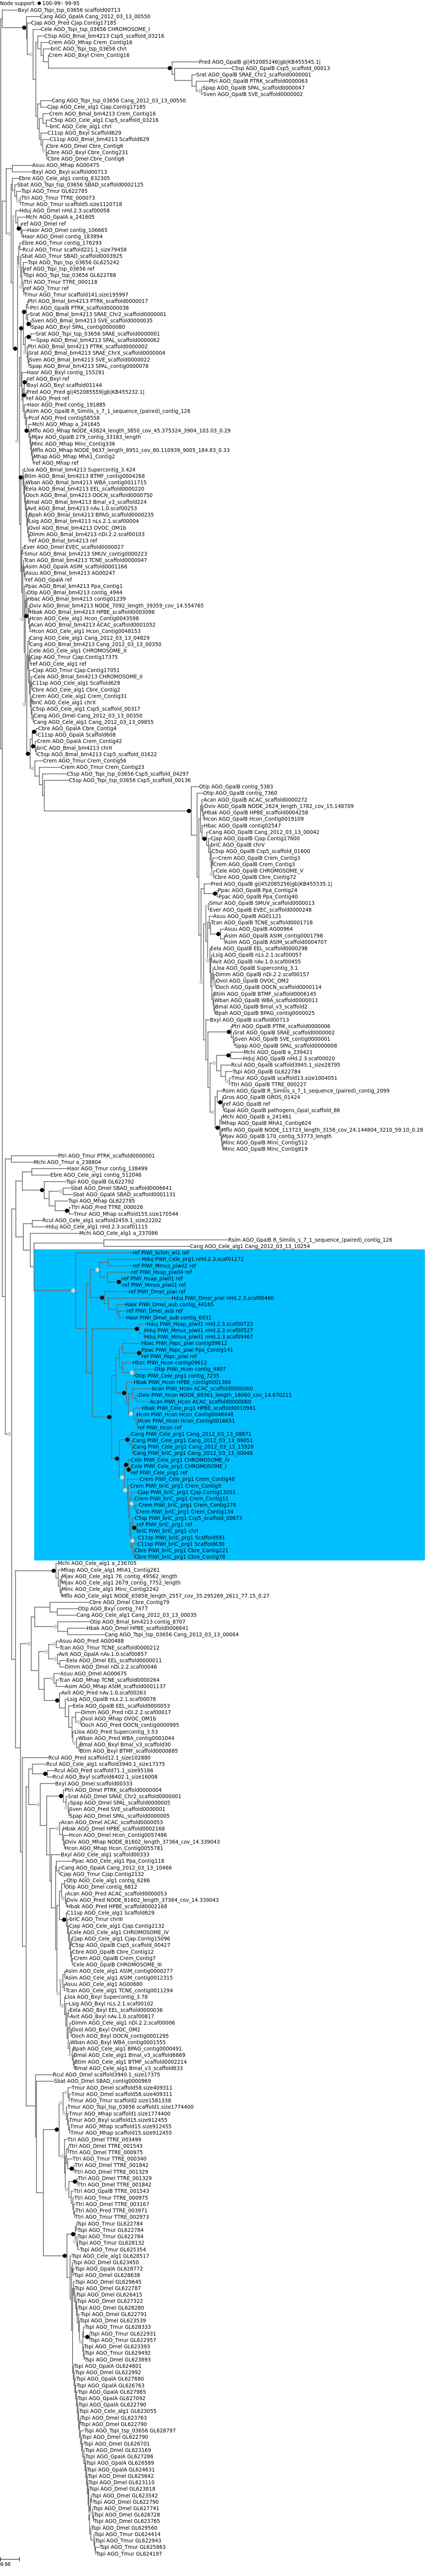

In [1]:
from IPython.display import Image
Image('silencing/exonerate/AGO.png')

# 8.8 RDRP tree
The pink clade is RRF3.

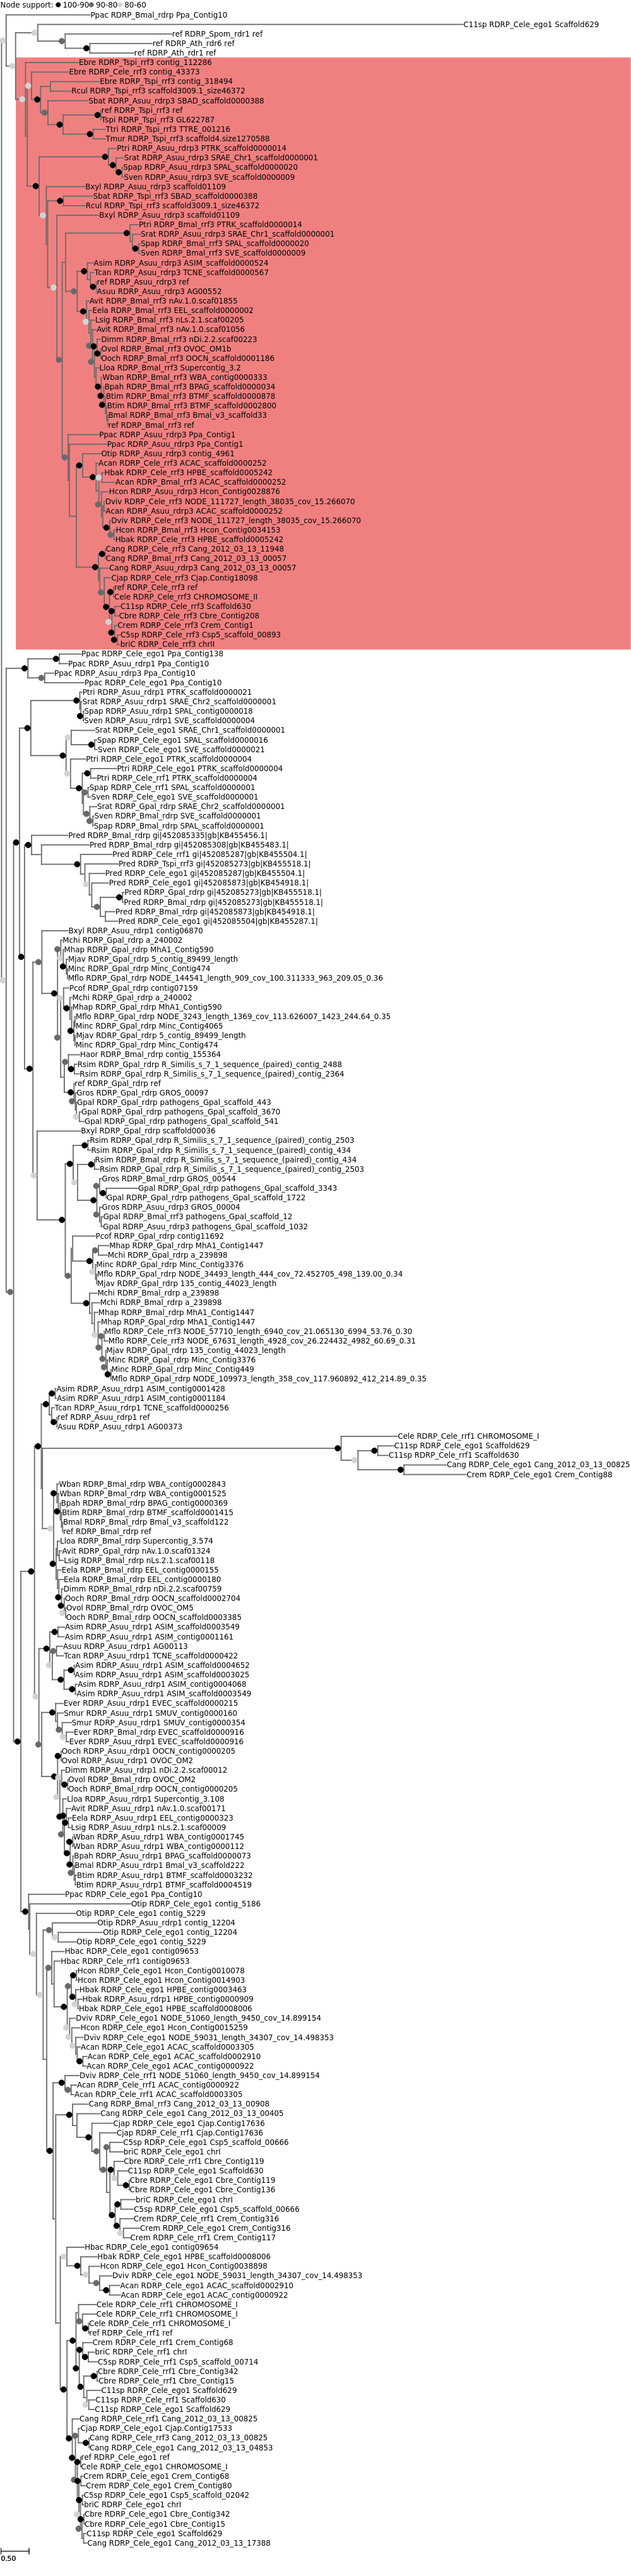

In [2]:
from IPython.display import Image
Image('silencing/exonerate/RDRP.png')

## 8.9 RRF3 serach in transcriptomes of *Enterobius vermicularis*, *Syphacia muris* and *Heterorhabditis bacteriophora*

#### Install misc

In [12]:
import os
if os.path.exists('/home/reprophylo/misc.py'):
    print('misc OK')
else:
    !wget https://github.com/HullUni-bioinformatics/misc/archive/master.zip
    !unzip master.zip
    !mv misc-master/misc.py /home/reprophylo/misc.py
    !rm -r misc-master/ master.zip
    if os.path.exists('/home/reprophylo/misc.py'):
        print('misc OK')
    else:
        print('could not install misc')

--2015-11-12 14:04:37--  https://github.com/HullUni-bioinformatics/misc/archive/master.zip
Resolving github.com (github.com)... 192.30.252.130
Connecting to github.com (github.com)|192.30.252.130|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/HullUni-bioinformatics/misc/zip/master [following]
--2015-11-12 14:04:38--  https://codeload.github.com/HullUni-bioinformatics/misc/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.252.146
Connecting to codeload.github.com (codeload.github.com)|192.30.252.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

    [ <=>                                   ] 4,982       --.-K/s   in 0s      

2015-11-12 14:04:39 (12.1 MB/s) - ‘master.zip’ saved [4982]

Archive:  master.zip
59f706e65b304136fde8bf55b4f1c8c0411a03e6
   creating: misc-master/
 extracting: misc-master/.gitignore  
 extracting: mis

#### Load the RNAi Proteins phylogenetic `Project`

In [117]:
from reprophylo import *
pr = unpickle_pj('silencing/reprophylo_project_relaxed_filter_fd_fJ', git=False)

#### Based on the RDRP tree figure above, specify reference sequences for the search

In [18]:
# Reference sequences
rrf3_ref = ['Osch|1fa|73','Anis|fa_4|3', 'loa_|asta|18', 'a_su|cfa|149']

#### Make a fasta file wih the reference sequences

In [64]:
with open('silencing/rrf3_ref.fasta','wt') as hndl:
    for r in pr.records:
        if r.id in rrf3_ref:
            for f in r.features:
                if f.type == 'CDS':
                    hndl.write('>%s\n%s\n'%(r.id,str(f.extract(r.seq))))


#### Align the reference sequences

In [65]:
from misc import *
clines = ['mafft silencing/rrf3_ref.fasta > silencing/rrf3_ref.aln.fasta']

for c in clines:
    out, err = execute_cline(c)
    print err


nseq =  4
distance =  ktuples
iterate =  0
cycle =  2
nthread = 0
generating 200PAM scoring matrix for nucleotides ... done
done
done
scoremtx = -1
Gap Penalty = -1.53, +0.00, +0.00

tuplesize = 6, dorp = d


Making a distance matrix ..
    1 / 4
done.

Constructing a UPGMA tree ... 
    0 / 4
done.

Progressive alignment ... 
STEP     3 / 3 d
done.

disttbfast (nuc) Version 7.123b alg=A, model=DNA200 (2),  1.530 ( 4.590), -0.000 (-0.000)
0 thread(s)
nthread = 0
blosum 62 / kimura 200
generating 200PAM scoring matrix for nucleotides ... done
done
done
scoremtx = -1
Gap Penalty = -1.53, +0.00, +0.00
Making a distance matrix .. 
    0 / 3
done.

Constructing a UPGMA tree ... 
    0 / 4
done.

Progressive alignment ... 
STEP     3 /3 d
done.
tbfast (nuc) Version 7.123b alg=A, model=DNA200 (2),  1.530 ( 4.590), -0.000 (-0.000)
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > o

#### Install HMMER

In [54]:
! sudo apt-get install hmmer -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
hmmer is already the newest version.
0 upgraded, 0 newly installed, 0 to remove and 212 not upgraded.


#### Specify transcriptome data fpaths

In [66]:
trans = {'Hbac': '../../Genomes/heterorhabditis_bacteriophora.PRJNA13977.WBPS4.mRNA_transcripts.fa',
         'Smur': '../../Genomes/syphacia_muris.PRJEB524.WBPS4.mRNA_transcripts.fa',
         'Ever': '../../Genomes/enterobius_vermicularis.PRJEB503.WBPS4.mRNA_transcripts.fa'}

#### Run HMMER and get the match sequences

In [69]:
from Bio import AlignIO, SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC

cline = 'nhmmer -o %s -A %s silencing/rrf3_ref.aln.fasta %s'

for sp in trans:
    # hmmer output
    out = 'silencing/'+sp+'.out'
    
    # hmmer alignment of matches
    alnout = 'silencing/'+sp+'.aln.out'
    
    # Run hmmer
    ot, err = execute_cline(cline%(out, alnout,trans[sp]))
    
    # Translate the matches and write to a fasta file
    if os.path.exists(alnout):
        
        # Open a fasta file to write
        with open(out+'.fasta','wt') as fasta:
            
            # Read the alignment
            aln = AlignIO.read(alnout,'stockholm')
            for r in aln:
                
                # remove gaps
                s = Seq(str(r.seq).replace('-',''), alphabet=IUPAC.ambiguous_dna)
                
                # Translate the right frame
                s = s.translate()
                if '*' in str(s):
                    s = Seq(str(r.seq)[1:].replace('-',''), alphabet=IUPAC.ambiguous_dna)
                    s = s.translate()
                if '*' in str(s):
                    s = Seq(str(r.seq)[2:].replace('-',''), alphabet=IUPAC.ambiguous_dna)
                    s = s.translate()
                print s
                
                fasta.write('>%s\n%s\n'%(r.id,str(s)))

DLLSVRAGFQLSAEPFFRSLIKASVKFSITKQLRKEQIQIPFEKGRSMLGVVDETGRLQYGQIFVQYTRN
GSDLDGDEYSVIWDEDLLLERNESMKRCSDLYGIDSEIPPE
HFVYLASSNSQMRDNGCYFFDDGEGGEAQKIRDNLGRFDIRNIPKLMSRMGQCFTQAERSSEVLLRKKYNKAHDFVGGKDANGESYTFSDGVGKLSLNFASRIAGKMGLGSFVPSCFQIRYRGIKGVLSVDPAIDERRHWAERHCVEDKGKEYNKTLDLDVLFRPSQDKFDSPRQKNIDIVKYSSPVPVALNRPLINIMDQVSEMQGHALHARVCGRVHSFLDRQLMEMAEMFMNEDSCRKRLNELPKRISVEYLKVVRGFALTQEPFFRSLLYASAKFTLKKQLAKEQIQVPIKLGRTMFGVVDESGLLQYGQVFIQYTCNIELKKPGKNAAKEILKGKVLITKNPSVVAGDVRVFNAIDIPELNHLVDVVVFPQSGPRPHPDEMAGSDLDGDEYSIIWDPELFFDHNEEPLDFTK
EQIQIPFNLGRSMFGIVDESGLLQYGQVFIQYTCSIESKTPGRCAAKKILKGKVLITKNPSVVAGDVRVFEAVDIPELQHLVDVVVFPQSGPRPHPDEMAGSDLDGDEYSIIWDPELIFDHNEEAFDFTKNAREPEEVSHDEVVAEMRNFFVKYIKQDSIGSISNAFLVNADLYGIKSEHSLSVDFPKTGTPPDPLVKKWGVSVDGVPLPPEKPERWPEFMCKNHVPFYASRRLVGQLYRRIKAVDDILTLTMASEELAPIKIDETLLVPNYDHFVNEAEEDFAAYSSYIISLMDNYGIEDEGQLYSGCIIMLRNRLSEKDNDDMSLYNTNYMIEKKVTDIFKTFRKRFFTEFGGFEACTTVVSSKEFATFEKDLRRVCKDPTTKMKAKASAYYYVCYKNASHSSGKRLLSFPWLVWDILAQVKTCNIGT
VRKMIVTPTRTLLVVPELLMGNRVLRTFDETGDGALRV

#### Add the new sequences to the Project as the RDRP Locus

In [120]:
files = ['silencing/Ever.out.fasta',
         'silencing/Hbac.out.fasta',
         'silencing/Smur.out.fasta']

pr.read_denovo(files,'prot')

from itertools import chain
new_records = [r.id for r in chain(*[list(SeqIO.parse(f,'fasta')) for f in files])]

for r in pr.records:
    quals = r.features[0].qualifiers
    if 'original_id' in quals and quals['original_id'][0] in new_records:
        pr.add_feature_to_record(r.id, 'CDS', qualifiers={'gene':'RDRP', 'translation':str(r.seq)})
        print r.format('gb')

LOCUS       denovo33                 417 aa                     UNK 01-JAN-1980
DEFINITION  EVEC_0000545101-mRNA-1/1513-2763
ACCESSION   denovo33
VERSION     denovo33
KEYWORDS    .
SOURCE      .
  ORGANISM  .
            .
FEATURES             Location/Qualifiers
     source          1..417
                     /feature_id="denovo33_source"
                     /original_id="EVEC_0000545101-mRNA-1/1513-2763"
                     /original_desc
     CDS             1..417
                     /prot_degen_prop="0.0"
                     /nuc_degen_prop="0.836930455635"
                     /feature_id="denovo33_f0"
                     /translation="HFVYLASSNSQMRDNGCYFFDDGEGGEAQKIRDNLGRFDIRNIPK
                     LMSRMGQCFTQAERSSEVLLRKKYNKAHDFVGGKDANGESYTFSDGVGKLSLNFASRIA
                     GKMGLGSFVPSCFQIRYRGIKGVLSVDPAIDERRHWAERHCVEDKGKEYNKTLDLDVLF
                     RPSQDKFDSPRQKNIDIVKYSSPVPVALNRPLINIMDQVSEMQGHALHARVCGRVHSFL
                     DRQLMEMAEMFMNEDSCRKRLNELPKRISVEYLK

In [122]:
pr.extract_by_locus()
len(pr.records_by_locus['RDRP'])

342

#### Rebuild the RDRP tree

In [123]:
alnconf = AlnConf(pr, method_name='MafftWithHmmerSeqs', loci=['RDRP'])

mafft 693281447348321.1_RDRP.fasta


In [124]:
pr.align([alnconf])

In [126]:
trimconf = TrimalConf(pr, method_name='gappyoutWithHmmerSeqs', alns=['RDRP@MafftWithHmmerSeqs'])

trimal -in 379501447348426.29_RDRP@MafftWithHmmerSeqs.fasta -gappyout


In [127]:
pr.trim([trimconf])

Alignment RDRP@MafftWithHmmerSeqs@gappyoutWithHmmerSeqs has undetermined sequences (1 bp or less) which will be dropped: ['Acan|0fa|144_f0', 'Acan|0fa|153_f0', 'Anis|fa_4|253_f0', 'melo|tfa|208_f0', 'c_sp|cfa|376_f0', 'Diro|2fa|159_f0', 'Caen|sfa|203_f0', 'Brug|fa_4|172|1943_f0', 'Onch|fa_4|90|2056_f0', 'Onch|fa_4|157|2123_f0']


In [128]:
treeconf = RaxmlConf(pr, method_name='faWithHmmerSeqs', alns=['RDRP@MafftWithHmmerSeqs@gappyoutWithHmmerSeqs'])

raxmlHPC-PTHREADS-SSE3 -f a -m PROTGAMMAJTT -n 714251447348556.87_RDRP@MafftWithHmmerSeqs@gappyoutWithHmmerSeqs0 -p 184 -s 714251447348556.87_RDRP@MafftWithHmmerSeqs@gappyoutWithHmmerSeqs.fasta -T 4 -x 690 -N 100


In [129]:
pr.tree([treeconf])

#### Check where the HMMER cluster

In [130]:
# Make a copy of the tree object
newtree = pr.ft('faWithHmmerSeqs')

returning tree object RDRP@MafftWithHmmerSeqs@gappyoutWithHmmerSeqs@faWithHmmerSeqs


In [138]:
# Root the tree
newtree.set_outgroup(newtree.get_midpoint_outgroup())

# Report the location of the new sequences
for origid in new_records:
    
    # Find the new leaf
    node = newtree.search_nodes(source_original_id = origid)[0]
    
    # Get its parent
    parent = node.up.up
    
    # Report the parent
    print origid
    print node.name
    print parent.get_ascii(attributes=["name","source_code", "source_qname",'source_tid'], show_internal=False)
    print

EVEC_0000545101-mRNA-1/1513-2763
denovo33_f0

   /-Ente|fa_4|86_f0, Ever, RDRP_Asuu_rdrp1, EVEC_scaffold0000916
--|
  |   /-Ente|fa_4|79_f0, Ever, RDRP_Bmal_rdrp, EVEC_scaffold0000916
   \-|
      \-denovo33_f0

Hba_03302/1231-1442
denovo34_f0

      /-denovo34_f0
   /-|
--|   \-Hete|sfa|78_f0, Hbac, RDRP_Cele_ego1, contig09653
  |
   \-denovo35_f0

Hba_03303/1543-1665
denovo35_f0

      /-Hete|sfa|84_f0, Hbac, RDRP_Cele_rrf1, contig09653
     |
     |         /-Heli|fa_4|186_f0, Hbak, RDRP_Asuu_rdrp1, HPBE_contig0000909
     |      /-|
     |     |  |   /-Heli|fa_4|243_f0, Hbak, RDRP_Cele_ego1, HPBE_contig0003463
     |     |   \-|
   /-|   /-|      \-Heli|fa_4|133_f0, Hbak, RDRP_Cele_ego1, HPBE_scaffold0008006
  |  |  |  |
  |  |  |  |   /-h_co|cfa|285_f0, Hcon, RDRP_Cele_ego1, Hcon_Contig0010078
  |  |  |   \-|
  |  |  |      \-h_co|cfa|246_f0, Hcon, RDRP_Cele_ego1, Hcon_Contig0014903
  |  |  |
  |   \-|      /-h_co|cfa|234_f0, Hcon, RDRP_Cele_ego1, Hcon_Contig0015259
  |     |     